In [0]:
!pip install kaggle
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

!kaggle competitions download -c pubg-finish-placement-prediction

!unzip train_V2.csv.zip
!unzip test_V2.csv.zip
!unzip sample_submission_V2.csv.zip

Download 100%.
sample_submission_V2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_V2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_V2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train_V2.csv.zip
replace train_V2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test_V2.csv.zip
replace test_V2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  sample_submission_V2.csv.zip
replace sample_submission_V2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# IMPORTING DATA AND DATA STATISTICS

In [0]:
#ALL IMPORTS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc 
sns.set(style = "whitegrid")


from google.colab import files

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
!pip install lightgbm
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from keras import models
from keras import layers
from keras import Sequential
from keras import optimizers
from keras.layers import Dense, Dropout, Input, BatchNormalization
!wget https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py
import utils
import os
import keras
from keras.callbacks import ModelCheckpoint
from utils import GDriveSync
from keras.models import load_model
!pip install wordcloud
from wordcloud import WordCloud

from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

Using TensorFlow backend.


--2018-12-08 19:31:29--  https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6935 (6.8K) [text/plain]
Saving to: ‘utils.py.6’

utils.py.6          100%[===================>]   6.77K  --.-KB/s    in 0s      

2018-12-08 19:31:29 (92.7 MB/s) - ‘utils.py.6’ saved [6935/6935]

--2018-12-08 19:31:36--  https://raw.githubusercontent.com/mixuala/colab_utils/master/tboard.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘tboard.py’

tboard.py  

In [0]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [0]:
#Read training data from csv and remove records with NA values
train = pd.read_csv('train_V2.csv', header=0, sep=',', quotechar='"')
train.dropna(inplace=True)
print(len(train))
pd.options.display.max_columns = 2000
train.head()

4446965


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [0]:
#Read test data from csv and remove records with NA values
test = pd.read_csv('test_V2.csv', header=0, sep=',', quotechar='"')
test.dropna(inplace=True)
print(len(test))
test.head()

1934174


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,0,0,0,0.00,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,0,2,1,361.90,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,0,0,0,0.00,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,0,0,0,0.00,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,0,3,1,60.06,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [0]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06
mean,2.338150e-01,1.106908e+00,1.307172e+02,6.578757e-01,2.268196e-01,1.370148e+00,4.759936e+01,5.050062e+02,9.247835e-01,5.439553e-01,2.299760e+01,1.579507e+03,4.450468e+01,4.300760e+01,8.920103e+02,1.646590e-01,6.061158e+02,3.496092e-03,4.509323e+00,2.386841e-02,7.918209e-03,1.154218e+03,3.660488e+00,6.064603e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746293e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587388e+02,2.382810e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261158e-02,1.183497e+03,2.456543e+00,7.397005e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.330000e+02,2.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.910000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [0]:
#FEATURE DESCRIPTIONS
'''
DBNOs - Number of enemy players knocked.  //Ratio, Discrete

assists - Number of enemy players this player damaged that were killed by teammates.  //Ratio, Discrete

boosts - Number of boost items used.   //Ratio, Discrete

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.   //Ratio, Continuous

headshotKills - Number of enemy players killed with headshots.  //Ordinal, Discrete

heals - Number of healing items used.   //Ratio, Discrete

Id - Player’s Id   //Nominal, Discrete

killPlace - Ranking in match of number of enemy players killed.   //Ordinal, Discrete

killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
//Ratio, Discrete

killStreaks - Max number of enemy players killed in a short amount of time.  //Ratio, Discrete


kills - Number of enemy players killed. ////Ordinal, Discrete    [Max 99, Min 0]


longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat. //Ratio, Cont.


matchDuration - Duration of match in seconds.  //Ratio, Continuous


matchId - ID to identify match. There are no matches that are in both the training and testing set.  //Nominal, Discrete


matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches
//Nominal,Discrete

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
//RATIO, Discrete

revives - Number of times this player revived teammates.  //Ratio, Discrete

rideDistance - Total distance traveled in vehicles measured in meters.  //Ratio, Continuous

roadKills - Number of kills while in a vehicle. //Ordinal, Discrete

swimDistance - Total distance traveled by swimming measured in meters.  //Ratio, Continuous

teamKills - Number of times this player killed a teammate.  //Ordinal, Discrete

vehicleDestroys - Number of vehicles destroyed.  //Ratio, Discrete

walkDistance - Total distance traveled on foot measured in meters. //Ratio, Continuous

weaponsAcquired - Number of weapons picked up. //Ratio, Continuous

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
//Ratio, Discrete

groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time. //Nominal

numGroups - Number of groups we have data for in the match. //Ordinal, Discrete

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements. //Ordinal, Discrete

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.
//Ratio, Continuous

'''

'\nDBNOs - Number of enemy players knocked.  //Ratio, Discrete\n\nassists - Number of enemy players this player damaged that were killed by teammates.  //Ratio, Discrete\n\nboosts - Number of boost items used.   //Ratio, Discrete\n\ndamageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.   //Ratio, Continuous\n\nheadshotKills - Number of enemy players killed with headshots.  //Ordinal, Discrete\n\nheals - Number of healing items used.   //Ratio, Discrete\n\nId - Player’s Id   //Nominal, Discrete\n\nkillPlace - Ranking in match of number of enemy players killed.   //Ordinal, Discrete\n\nkillPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.\n//Ratio, Discrete\n\nkillStreaks - Max number of enemy players killed in a short amount of time.  //Ratio, Discrete\n\n\nkills - Number of enemy players killed. ////Ord

# DATA INSIGHTS

In [0]:
def plot_hist(x, title, noOfBins=50, col="#25203e"):
    
    fig, ax = plt.subplots(figsize=(8,8))
    formatter = plt.FuncFormatter(lambda x, y: '{:,.2f}'.format(x))
    
    
    ax.yaxis.set_major_formatter(formatter=formatter)
    ax.xaxis.set_major_formatter(formatter=formatter)

    sns.distplot(x, bins=noOfBins, kde=False, color=col)
    plt.xlabel('WinPlacePercentile',fontsize = 15,color='black')
    plt.ylabel('Frequency',fontsize = 15,color='black')
    plt.title(title,fontsize = 20,color='black')
    plt.savefig(title+'.png',format='png',dpi=800)    
    files.download(title+'.png')
    
def plot_hist1(x, title, noOfBins=50, col="#25203e"):
    
    fig, ax = plt.subplots(figsize=(10,8))
    formatter = plt.FuncFormatter(lambda x, y: '{:,.2f}'.format(x))
    
    
    ax.yaxis.set_major_formatter(formatter=formatter)
    ax.xaxis.set_major_formatter(formatter=formatter)
    plt.xlim(0.3,0.65)

    sns.distplot(x, bins=noOfBins, kde=False, ax=ax, color=col)
    plt.xlabel('Average Win Place Percentile of a Match',fontsize = 15,color='black')
    plt.ylabel('Frequency',fontsize = 15,color='black')
    plt.title('Histogram of Average Win Place Percentile of a Match',fontsize = 20,color='black')
    plt.savefig(title+'.png',format='png',dpi=800)    
    files.download(title+'.png')

In [0]:
print('The average winning percentile is {:.3f}, the median is {:.3f}'.format(train.winPlacePerc.mean(), train.winPlacePerc.median()))

The average winning percentile is 0.473, the median is 0.458


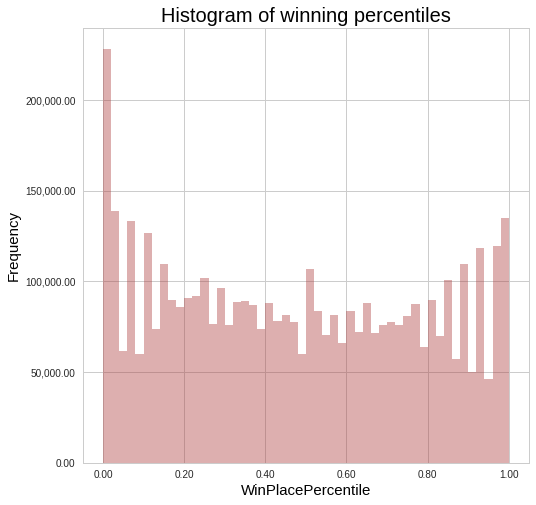

In [0]:
plot_hist(train.winPlacePerc, title='Histogram of winning percentiles', col = '#AA3939')

From the graph , we can see that our percentile distribution isn't exactly as uniform as we expected.There seems to be more cases occuring at low percentiles. This indicates that overall, we have more losers than winners.

The higher counts at the percentile extremes is to be expected. There is always some someone getting the percentiles scores of zero and 1, the rest of the scores varying across different matches.

Let's consider the average winning percentile per match and look at the distribution. As mentioned earlier, we should expect a normal distirbution with mean 0.5

In [0]:
train = train.assign(match_mean=train.groupby('matchId').winPlacePerc.transform('mean'))
train = train.assign(match_median = train.groupby('matchId').winPlacePerc.transform('median'))

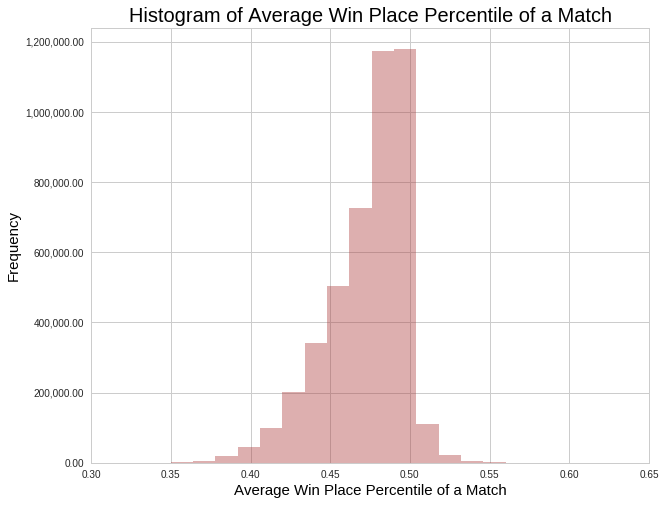

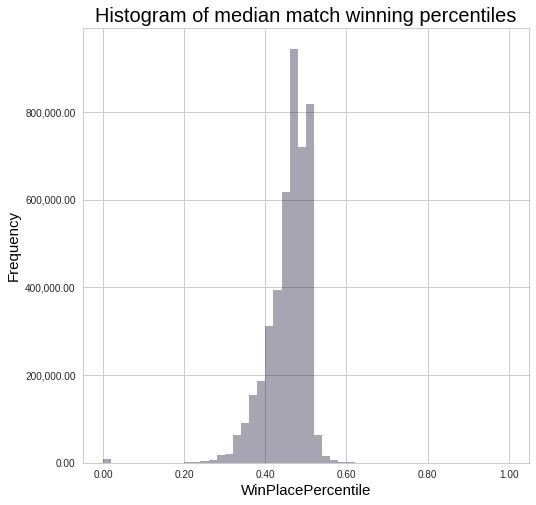

In [0]:
plot_hist1(train.match_mean, title='Histogram of average match winning percentiles', col='#AA3939')
plot_hist(train.match_median, title='Histogram of median match winning percentiles');

We expect that these values should resemble a normal distribution. But, what we find is that the mean distribution is somewhat right-tailed. 

We can infer that some games have lower average percentiles. The reason for this can be players leaving the game before it finishes. This leads to more people and teams having lower ranks 

In [0]:
train.drop(['match_mean','match_median'], axis=1)
# data.drop('match_median')
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'match_mean',
       'match_median'],
      dtype='object')

## Pearson correlation between variables

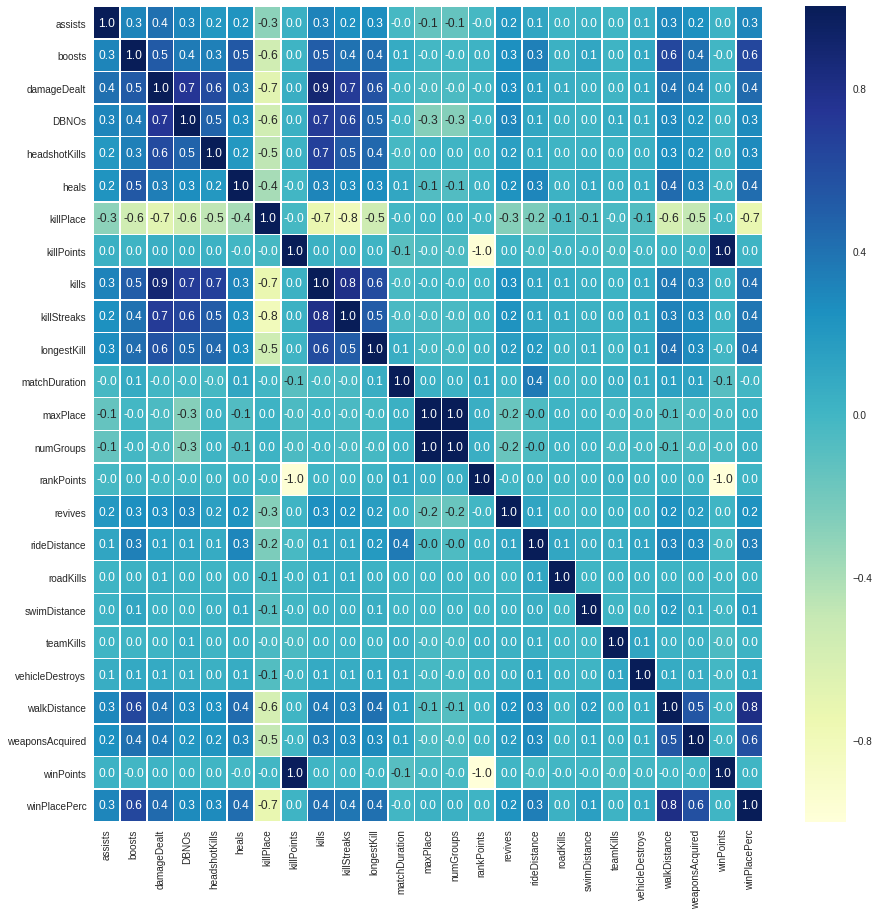

In [0]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.iloc[:,:-2].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="YlGnBu", vmin=-1, vmax =1)
plt.savefig('Corelation_all.png',format='png', dpi = 1500)
files.download('Corelation_all.png')
plt.show()

In [0]:
#Mean of all matches
train.groupby('matchId').mean()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,match_mean,match_median
matchId,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000a43bce5eec,0.357895,1.242105,142.523905,0.842105,0.178947,1.115789,48.0,1321.547368,0.947368,0.547368,19.781053,1346.0,28.0,28.0,0.000000,0.157895,92.631226,0.000000,3.761547,0.010526,0.021053,1253.503021,3.073684,1490.631579,0.459261,0.459261,0.44440
0000eb01ea6cdd,0.265306,1.071429,134.407449,0.908163,0.265306,1.122449,49.5,0.000000,0.969388,0.632653,16.598020,1363.0,28.0,27.0,1484.714286,0.214286,81.256799,0.000000,5.538724,0.000000,0.000000,1082.208704,3.448980,0.000000,0.466364,0.466364,0.46295
0002912fe5ed71,0.031579,1.252632,112.595789,0.000000,0.263158,1.389474,48.0,0.000000,0.894737,0.463158,30.028463,1949.0,95.0,92.0,1510.631579,0.000000,1564.827368,0.021053,10.081642,0.021053,0.031579,1218.072305,4.031579,0.000000,0.489024,0.489024,0.48940
0003b92987589e,0.220000,0.790000,112.365500,0.590000,0.210000,0.820000,50.5,0.000000,0.950000,0.610000,22.461675,1410.0,50.0,47.0,1508.470000,0.110000,87.221000,0.000000,13.279286,0.010000,0.000000,973.116800,3.230000,0.000000,0.476326,0.476326,0.50000
0006eb8c17708d,0.236559,1.118280,134.813796,0.580645,0.215054,1.494624,47.0,1224.139785,0.913978,0.559140,23.328387,1382.0,47.0,44.0,-1.000000,0.129032,223.770240,0.000000,6.172333,0.000000,0.000000,958.819140,3.387097,1509.225806,0.492520,0.492520,0.47830
00077604e50a63,0.438776,1.030612,144.266429,0.948980,0.224490,1.244898,49.5,0.000000,0.938776,0.571429,19.848153,1452.0,30.0,29.0,1463.928571,0.275510,139.991633,0.000000,3.650291,0.040816,0.000000,1182.149696,3.622449,0.000000,0.488035,0.488035,0.50000
00086c74bb4efc,0.193878,1.295918,127.982755,0.612245,0.265306,1.224490,49.5,0.000000,0.969388,0.581633,16.585694,1465.0,49.0,48.0,1535.704082,0.122449,157.640008,0.010204,2.715163,0.010204,0.010204,996.651827,3.377551,0.000000,0.488307,0.488307,0.48960
00086e740a5804,0.051020,1.224490,124.745714,0.000000,0.285714,1.326531,49.5,0.000000,0.857143,0.469388,19.579429,1962.0,98.0,95.0,1534.591837,0.000000,957.476122,0.000000,8.748469,0.051020,0.010204,1036.960520,3.673469,0.000000,0.495581,0.495581,0.50000
001125344b660c,0.187500,1.218750,128.808437,0.677083,0.187500,1.343750,48.5,0.000000,0.916667,0.593750,16.393302,1421.0,50.0,47.0,1519.687500,0.229167,218.606250,0.010417,8.419156,0.031250,0.020833,864.504865,3.395833,0.000000,0.464072,0.464072,0.43880


In [0]:
#Number of unique matches w.r.t to number of unique players
train['groupId'].value_counts()
len(train['groupId'].value_counts())

len(train['Id'].value_counts())

4446965

## PCA

In [0]:
y = train['winPlacePerc']
X = train.drop(['winPlacePerc','Id','matchId','groupId'],axis=1)

In [0]:
pca = PCA()
X['matchType'],_ = pd.factorize(X['matchType'])


In [0]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
print(pca.explained_variance_ratio_)  

[4.83922111e-01 2.80616200e-01 2.16238835e-01 1.10309681e-02
 4.88548388e-03 2.03255479e-03 5.36838908e-04 3.10483610e-04
 1.94594853e-04 1.71875780e-04 5.69238369e-05 1.06152360e-06
 7.48085372e-07 5.35437952e-07 2.38643571e-07 2.12737244e-07
 1.08678567e-07 7.75365406e-08 5.14278056e-08 3.58088384e-08
 3.42389775e-08 1.83767248e-08 5.30341550e-09 1.57844581e-09
 1.00842268e-09 4.53690713e-10 2.70724081e-11]


In [0]:
print(pca.singular_values_)  

[3.35508479e+06 2.55488959e+06 2.24275902e+06 5.06550305e+05
 3.37108388e+05 2.17438727e+05 1.11747485e+05 8.49835965e+04
 6.72792964e+04 6.32299893e+04 3.63883908e+04 4.96913268e+03
 4.17149136e+03 3.52915183e+03 2.35608327e+03 2.22452623e+03
 1.58996556e+03 1.34297824e+03 1.09374168e+03 9.12663922e+02
 8.92434108e+02 6.53807386e+02 3.51231609e+02 1.91615486e+02
 1.53157077e+02 1.02729627e+02 2.50945384e+01]


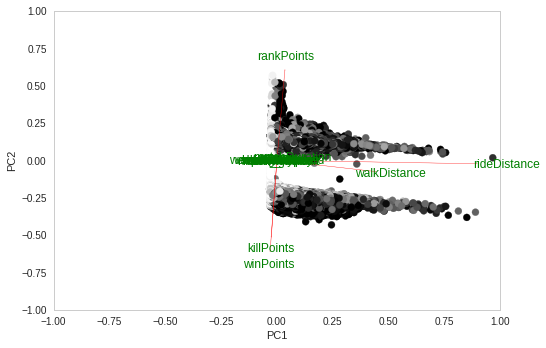

In [0]:
#BIPLOT OF PCA
X_new = pca.fit_transform(X)
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, X.columns[i], color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(X_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()
plt.savefig('PCA BiPlot.jpg', dpi = 1000)

#FEATURE ENGINEERING

In [0]:
def set_categorical(data):


  #Convert to categorical and assign a numeric value for each unique value
  data.matchId = data.matchId.astype('category')
  data.matchId = data.matchId.cat.codes

  data.groupId = data.groupId.astype('category')
  data.groupId = data.groupId.cat.codes

set_categorical(train)
set_categorical(test)

In [0]:
def group_features(data):
  #Find the total players in the match that record is in by groupby on matchId and then counting the rows
  data['totalPlayers'] = data.groupby('matchId')['matchId'].transform('count')+1
  #Same thing for calculating the teamSize of the person in the record by groupby on groupId
  data['teamSize'] = data.groupby('groupId')['groupId'].transform('count')

  #colsToNormalize = ['DBNOs','assists','boosts','damageDealt','headshotKills','heals','killStreaks','revives','roadKills','vehicleDestroys','weaponsAcquired','winPoints','killPlace','kills','killPoints','winPlace']


  #Create a normalized version of kills->killsNorm and damageDealtNorm to normalize the data for a match of 100 players. Since not all matches have exactly 100 players, we can't compare the
  #data from a match of 50 players to a match of 100 players.
  colsToNormalize = ['kills','damageDealt']

  for x in colsToNormalize:
    data[str(x+'Norm')] = data[x]/data['totalPlayers']*100
    
    
group_features(train)
group_features(test)

In [0]:
def add_matchType(data):
  #Creating a new feature normMatchType consisting of solo, duo, squad or other values. Since the data contains discrepancies where a solo game has a team size of 2
  # or a squad game having team size >4, etc., we assign these the 'other' value while the normal team sizes 1 for solo, 2 for duo, <4 for squad and other for the rest.
  # Since the data also consists of data from custom games there are teamSize 10, 12, 94, etc. which are added in other value.

  solo = ['solo','solo-fpp','normal-solo-fpp','normal-solo']
  duo = ['duo','duo-fpp','normal-duo-fpp','normal-duo']
  squad = ['squad','squad-fpp','normal-squad-fpp','normal-squad']
  other = ['crashfpp','flaretpp','crashtpp','flarefpp']

  data['normMatchType'] = 'none'
  data.loc[data.eval("teamSize==1 & matchType in @solo & normMatchType=='none'"),'normMatchType'] = 'solo'
  data.loc[data.eval("teamSize<=2 & matchType in @duo & normMatchType=='none'"),'normMatchType'] = 'duo'
  data.loc[data.eval("teamSize<=4 & matchType in @squad & normMatchType=='none'"),'normMatchType'] = 'squad'
  data.loc[data.eval("teamSize>0 & normMatchType=='none'"),'normMatchType'] = 'other'
  
  
add_matchType(train)
add_matchType(test)
    

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


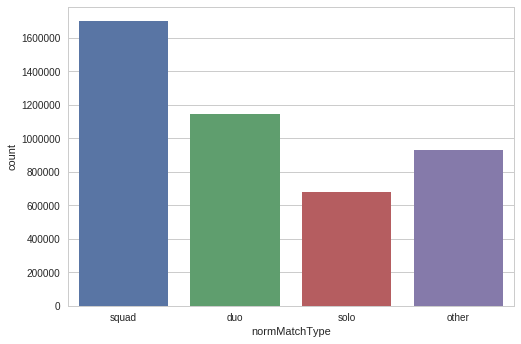

In [0]:
sns.countplot('normMatchType', data=train)

In [0]:
def feature_engineering(data):
  #Sum over the total distance travelled by the player including swim, ride and walk
  data['totalDistance'] = data.rideDistance+data.walkDistance+data.swimDistance
  data.totalDistance.fillna(0,inplace=True)
  data.totalDistance.replace(np.inf, 0, inplace=True)

  data['maxPossibleKills'] = data.totalPlayers-data.teamSize
  data.maxPossibleKills.fillna(0,inplace=True)
  data.maxPossibleKills.replace(np.inf, 0, inplace=True)

  #Sum over all the items the player has used like boosts, heals, weapons, etc.
  data['itemsUsed'] = data.boosts + data.heals + data.weaponsAcquired
  data.itemsUsed.fillna(0,inplace=True)
  data.itemsUsed.replace(np.inf, 0, inplace=True)

  #Normalize the items used by the distance travelled to equate different sizes of matches
  data['itemsPerDistance'] = data.itemsUsed/data.totalDistance
  data.itemsPerDistance.fillna(0,inplace=True)
  data.itemsPerDistance.replace(np.inf, 0, inplace=True)

  #Normalize the kills performed by the distance travelled to equate different sizes of matches
  data['killsPerDistance'] = data.kills/data.totalDistance
  data.killsPerDistance.fillna(0,inplace=True)
  data.killsPerDistance.replace(np.inf, 0, inplace=True)

  #Normalize the damage dealt by the distance travelled to equate different sizes of matches
  data['damageDealtPerDistance'] = data.damageDealt / data.totalDistance
  data.damageDealtPerDistance.fillna(0,inplace=True)
  data.damageDealtPerDistance.replace(np.inf, 0, inplace=True)

  #The maximum kills a teammate of the player has performed
  data['maxTeamKills'] = data.groupby('groupId')['kills'].max()
  data.maxTeamKills.fillna(0,inplace=True)
  data.maxTeamKills.replace(np.inf, 0, inplace=True)

  #Total number of kills the team has performed in total
  data['totalTeamKills'] = data.groupby('groupId')['kills'].sum()
  data.totalTeamKills.fillna(0,inplace=True)
  data.totalTeamKills.replace(np.inf, 0, inplace=True)

  #Find the skill of a person by dividing number of headshots by number of kills. Killing with just one headshot proves skill of the person
  data['headshotKillRate'] = data.headshotKills/data.kills
  data.headshotKillRate.fillna(0,inplace=True)
  data.headshotKillRate.replace(np.inf, 0, inplace=True)

  #Find the total items the team has used combined
  data['itemsUsedPerTeam'] = data.groupby('groupId')['itemsUsed'].sum()
  data.itemsUsedPerTeam.fillna(0,inplace=True)
  data.itemsUsedPerTeam.replace(np.inf, 0, inplace=True)

  #Find the percentage of kills the players has performed based on maximum possible kills he can perform. This essentially normalizes the kills for different match sizes
  data['percKill'] = data.kills / data.maxPossibleKills
  data.percKill.fillna(0,inplace=True)
  data.percKill.replace(np.inf, 0, inplace=True)

  #Find the percentage of kills the team has performed based on maximum possible kills they can perform. This essentially normalizes the kills for different match sizes
  data['percTeamKills'] = data.totalTeamKills / data.maxPossibleKills
  data.percTeamKills.fillna(0,inplace=True)
  data.percTeamKills.replace(np.inf, 0, inplace=True)

  #Find the mean of killPlace for all players in the team. This essentially finds the overall performance of the whole team in general
  data['meanTeamKillPlace'] = data.groupby('groupId')['killPlace'].mean()
  data.meanTeamKillPlace.fillna(0,inplace=True)
  data.meanTeamKillPlace.replace(np.inf, 0, inplace=True)
  
  data.matchType = data.matchType.astype('category')
  data.matchType = data.matchType.cat.codes
  
  
feature_engineering(train)
feature_engineering(test)


In [0]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalPlayers,teamSize,killsNorm,damageDealtNorm,normMatchType,totalDistance,maxPossibleKills,itemsUsed,itemsPerDistance,killsPerDistance,damageDealtPerDistance,maxTeamKills,totalTeamKills,headshotKillRate,itemsUsedPerTeam,percKill,percTeamKills,meanTeamKillPlace
0,7f96b2f878858a,613774,30085,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,15,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,97,4,0.000000,0.000000,squad,244.8000,93,1,0.004085,0.000000,0.000000,1.0,2.0,0.0,9.0,0.000000,0.021505,50.333333
1,eef90569b9d03c,827822,32751,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,15,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,92,4,0.000000,99.423913,squad,1445.0445,88,5,0.003460,0.000000,0.063299,1.0,1.0,0.0,3.0,0.000000,0.011364,40.000000
2,1eaf90ac73de72,843520,3143,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,2,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755,99,2,0.000000,68.686869,duo,161.8000,97,2,0.012361,0.000000,0.420272,0.0,0.0,0.0,2.0,0.000000,0.000000,72.000000
3,4616d365dd2853,1340461,45260,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,15,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667,92,1,0.000000,35.760870,squad,202.7000,91,3,0.014800,0.000000,0.162309,3.0,6.0,0.0,33.0,0.000000,0.065934,13.000000
4,315c96c26c9aac,1757848,20531,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,13,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875,98,1,1.020408,102.040816,solo,49.7500,97,2,0.040201,0.020101,2.010050,1.0,1.0,0.0,5.0,0.010309,0.010309,54.500000


In [0]:
#FLAG TO SHOW PLOTS OR NOT
flag = True

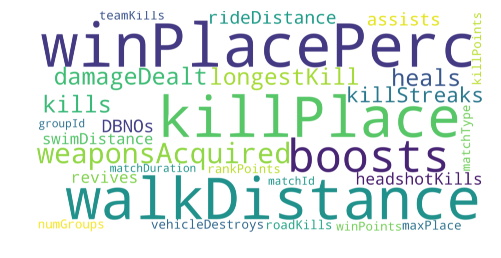

In [0]:
corr = train.iloc[:,:29].corr().iloc[27]
for x in range(len(corr)):
  corr[x] = abs(corr[x])+1



wordcloud = WordCloud(width=8000, height=4000,background_color="white")
wordcloud.generate_from_frequencies(frequencies=corr)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud1.png",format='png',dpi=1000)
plt.show()


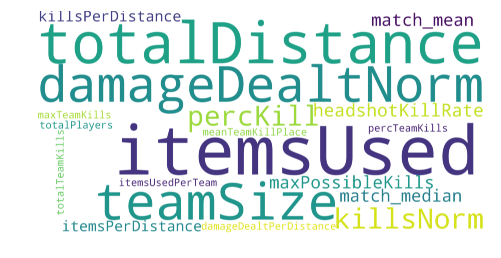

In [0]:
corr = train.iloc[:,28:].corr().iloc[0][1:]
for x in range(len(corr)):
  corr[x] = abs(corr[x])+1



wordcloud = WordCloud(width=8000, height=4000,background_color="white")
wordcloud.generate_from_frequencies(frequencies=corr)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud2.png",format='png',dpi=1000)
plt.show()

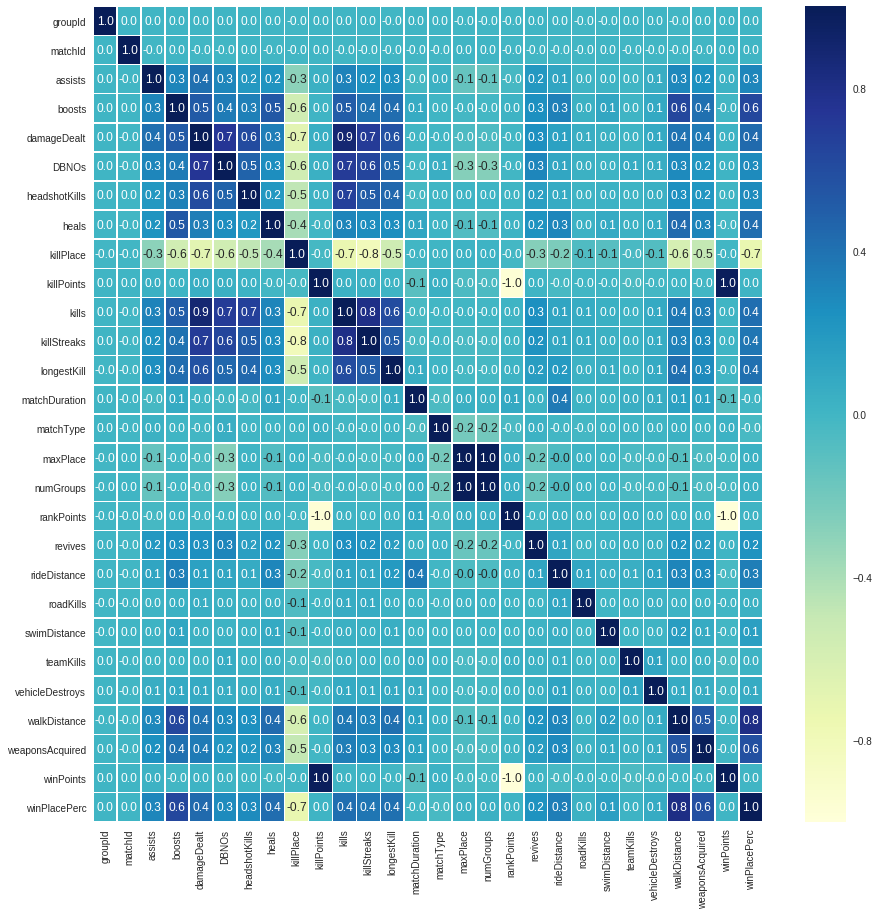

In [0]:
if flag==True:
  f,ax = plt.subplots(figsize=(15, 15))
  sns.heatmap(train.iloc[:,:29].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="YlGnBu", vmin=-1, vmax =1)
  plt.show()

In [0]:
def plot_hist3(x, title,binss=50):
    
    fig, ax = plt.subplots(figsize=(13,7))
    formatter = plt.FuncFormatter(lambda x, y: '{:,.2f}'.format(x))
    
    ax.yaxis.set_major_formatter(formatter=formatter)
    ax.xaxis.set_major_formatter(formatter=formatter)

    ax.set_title(title)
    sns.distplot(x, bins=binss, kde=False, ax=ax);

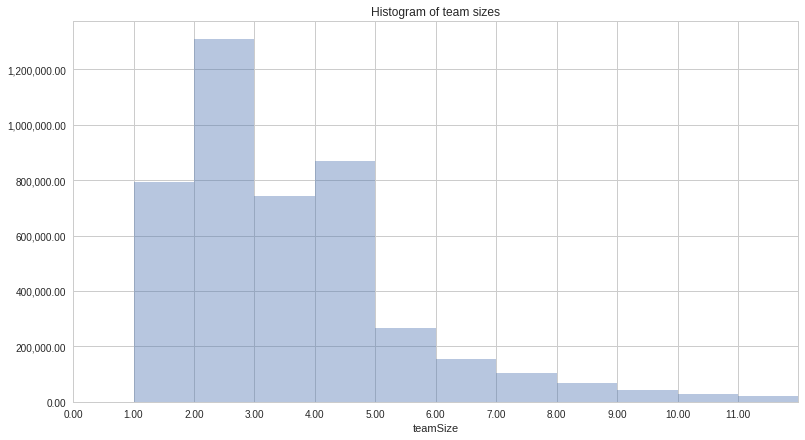

In [0]:
if flag==True:
  plot_hist3(train.teamSize, title='Histogram of team sizes',binss=73)
  #sns.distplot(data.teamSize, bins=50, kde=False);
  plt.xlim(0,12)
  plt.xticks(range(12))

In [0]:
train.normMatchType = train.normMatchType.astype('category')
train.normMatchType = train.normMatchType.cat.codes

test.normMatchType = test.normMatchType.astype('category')
test.normMatchType = test.normMatchType.cat.codes


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


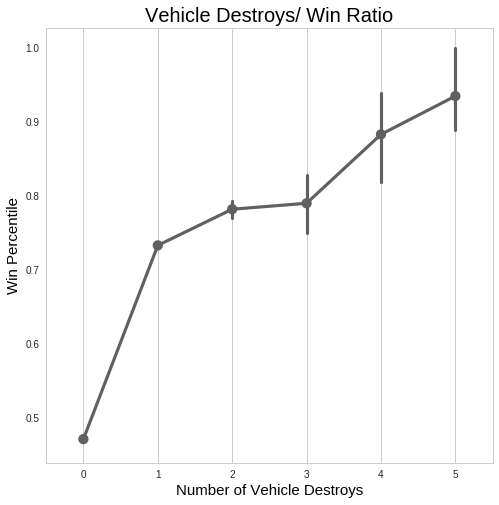

In [0]:
if flag==True:
  f,ax = plt.subplots(figsize=(8,8))
  sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=train,color='#606060',alpha=0.8)
  plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='black')
  plt.ylabel('Win Percentile',fontsize = 15,color='black')
  plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='black')
  plt.grid()
  plt.savefig("vehicle.png",dpi=1000)
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


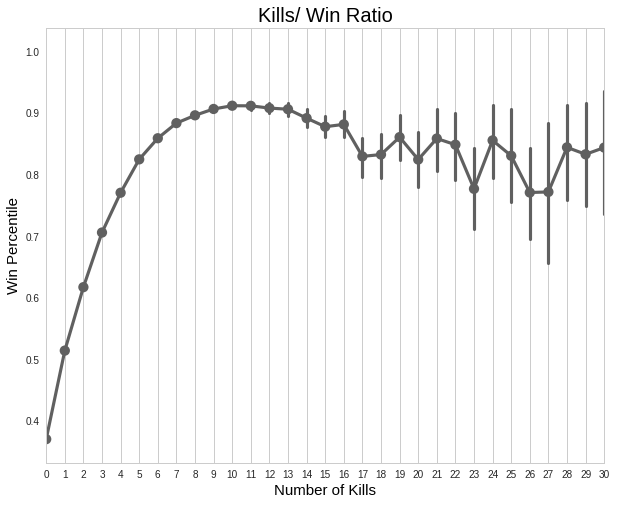

In [0]:
if flag==True:
  f,ax = plt.subplots(figsize=(10,8))
  sns.pointplot(x='kills',y='winPlacePerc',data=train,color='#606060',alpha=0.8)
  plt.xlim(0,30)
  plt.xlabel('Number of Kills',fontsize = 15,color='black')
  plt.ylabel('Win Percentile',fontsize = 15,color='black')
  plt.title('Kills/ Win Ratio',fontsize = 20,color='black')
  plt.grid()
  plt.savefig("kills.png",dpi=1000)
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


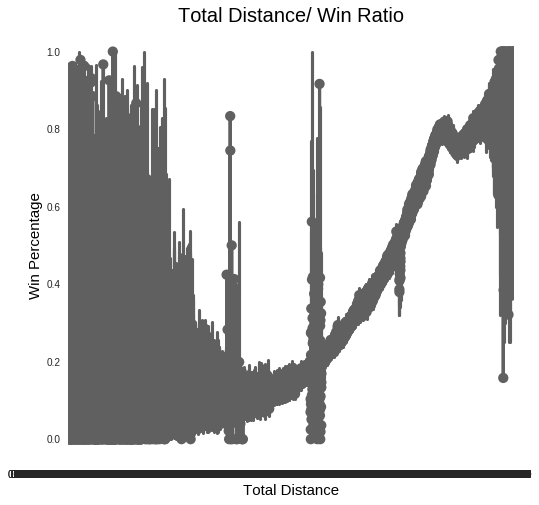

In [0]:
if flag==True:
  f,ax = plt.subplots(figsize=(8,8))
  sns.pointplot(x='totalDistance',y='winPlacePerc',data=train,color='#606060',alpha=0.8)
  plt.xlabel('Total Distance',fontsize = 15,color='black')
  plt.ylabel('Win Percentage',fontsize = 15,color='black')
  plt.title('Total Distance/ Win Ratio',fontsize = 20,color='black')
  plt.grid()
  plt.savefig("dist.png",dpi=600)
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


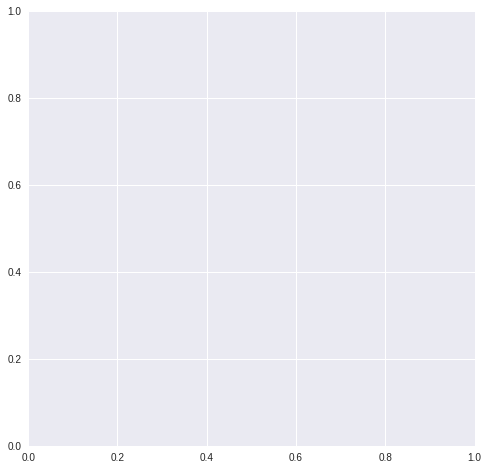

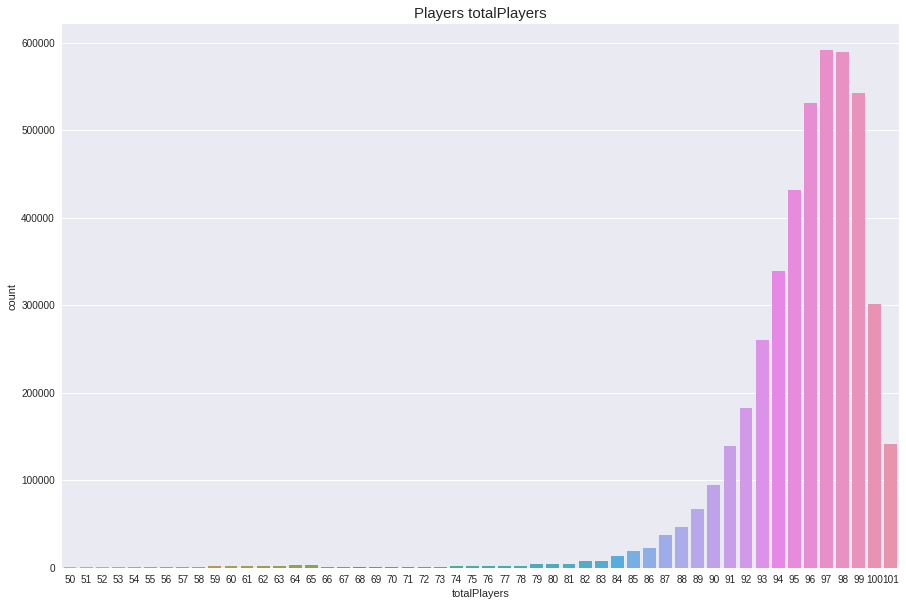

In [0]:
if flag==True:
  f,ax = plt.subplots(figsize=(8,8))
  highPlayer = train[train['totalPlayers']>49]
  plt.figure(figsize=(15,10))
  sns.countplot(highPlayer['totalPlayers'])
  plt.title("Players totalPlayers",fontsize=15)
  plt.savefig("totalplayers.png",dpi=600)
  plt.show()

In [0]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
y = train['winPlacePerc']
X = train.drop(['winPlacePerc','matchId','groupId','Id'],axis=1)

#y_test = test['winPlacePerc']
X_test = test.drop(['matchId','groupId','Id'],axis=1)

X.shape[1]

43

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7)

len(X_train)

del train,test,X,y

#X_train = X
#y_train = y
gc.collect()


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


118

# Model Selection

## LightGBM

In [0]:
def calculate_error(cl,name):
  print(name)
  print('Mean Absolute Error is {:.5f}'.format(mean_absolute_error(y_val, cl.predict(X_val))))
  print('R2 score is {:.2%}'.format(r2_score(y_val, cl.predict(X_val))))

In [0]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.05,0.1,0.3,0.002],
    'n_estimators': [50,250],
    'num_leaves': [6,10,16,200],
    'boosting_type' : ['gbdt','dart','goss','rf'],
    'objective' : ['mae'],
    }



mdl = LGBMRegressor(boosting_type= 'gbdt',
          objective = 'mae',
          n_estimators=250,
          learning_rate=0.3, 
          num_leaves=200, 
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = -1, 
          verbose=2,
          random_state=212)


# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=2,
                    n_jobs=2)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

NameError: ignored

### Since, grid search takes a long time to run, we couldn't run it when compiling it in a final notebook

In [0]:
RANDOM_STATE=212
#train_weights = (1/X_train.teamSize)
#validation_weights = (1/X_test.teamSize)
TARGET = 'winplaceperc'
TRAIN_SIZE = 0.9
EARLY_STOP_ROUNDS = 10
time_0 = datetime.datetime.now()

lgbm = LGBMRegressor(objective='mae', n_estimators=250,  
                     learning_rate=0.3, num_leaves=200, 
                     n_jobs=-1,  random_state=RANDOM_STATE, verbose=1)

lgbm.fit(X_train, y_train,
         eval_set=[(X_val, y_val)], 
         eval_metric='mae', early_stopping_rounds=EARLY_STOP_ROUNDS, 
         verbose=1)

time_1  = datetime.datetime.now()

print('Training took {} seconds. Best iteration is {}'.format((time_1 - time_0).seconds, lgbm.best_iteration_))

[1]	valid_0's l1: 0.19286
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 0.144091
[3]	valid_0's l1: 0.112807
[4]	valid_0's l1: 0.0921878
[5]	valid_0's l1: 0.0795694
[6]	valid_0's l1: 0.0716605
[7]	valid_0's l1: 0.0662104
[8]	valid_0's l1: 0.062826
[9]	valid_0's l1: 0.0609746
[10]	valid_0's l1: 0.0597035
[11]	valid_0's l1: 0.0588803
[12]	valid_0's l1: 0.0582907
[13]	valid_0's l1: 0.057764
[14]	valid_0's l1: 0.0570726
[15]	valid_0's l1: 0.0568547
[16]	valid_0's l1: 0.0566102
[17]	valid_0's l1: 0.0563797
[18]	valid_0's l1: 0.0562149
[19]	valid_0's l1: 0.0560829
[20]	valid_0's l1: 0.0560049
[21]	valid_0's l1: 0.0558181
[22]	valid_0's l1: 0.0557295
[23]	valid_0's l1: 0.0555972
[24]	valid_0's l1: 0.0555206
[25]	valid_0's l1: 0.0554388
[26]	valid_0's l1: 0.0553767
[27]	valid_0's l1: 0.0553458
[28]	valid_0's l1: 0.0553195
[29]	valid_0's l1: 0.0552607
[30]	valid_0's l1: 0.0552483
[31]	valid_0's l1: 0.0551807
[32]	valid_0's l1: 0.0551564
[33]	valid_0's l1: 0.0551

In [0]:
calculate_error(lgbm,"LGBM")

LGBM


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Mean Absolute Error is 0.05394
R2 score is 93.70%


In [0]:
y_predict = lgbm.predict(X_test)



In [0]:
y_predict

array([0.22722393, 0.9547446 , 0.70229252, ..., 0.88254854, 0.84077569,
       0.06085496])

In [0]:
sub = pd.read_csv('sample_submission_V2.csv', header=0, sep=',', quotechar='"')
sub.drop(['winPlacePerc'],axis=1 )
sub['winPlacePerc'] = y_predict
sub.head()

,Id,winPlacePerc
0,9329eb41e215eb,0.227224
1,639bd0dcd7bda8,0.954745
2,63d5c8ef8dfe91,0.702293
3,cf5b81422591d1,0.506421
4,ee6a295187ba21,0.947875


In [0]:
sub.to_csv("sample_submission.csv")

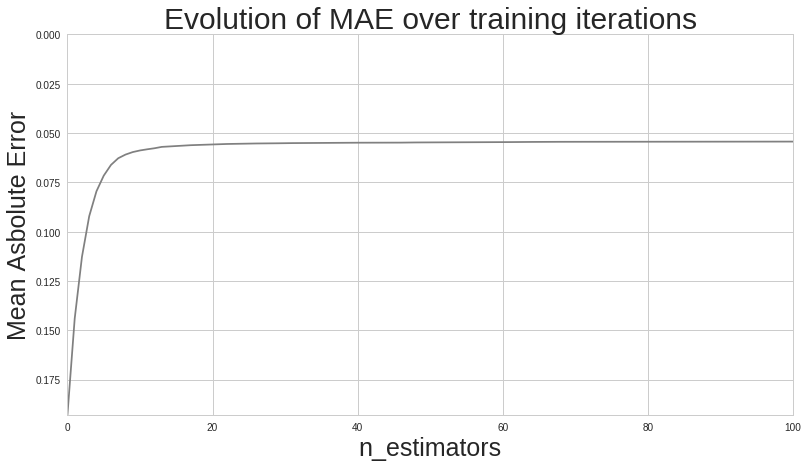

In [0]:
def plot_training(lgbm):
    
    fig, ax = plt.subplots(figsize=(13,7))
    plt.rcParams.update({"font.size":"20"})
    losses = lgbm.evals_result_['valid_0']['l1']
    ax.set_ylim(np.max(losses), 0)
    ax.set_xlim(0,100)
    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    
    plt.rc('ytick', labelsize=20)
    
    ax.set_xlabel('n_estimators',fontsize=25)
    ax.set_ylabel('Mean Asbolute Error',fontsize=25)
    ax.set_title('Evolution of MAE over training iterations',fontsize=30)
    ax.plot(losses, color='grey');
    plt.savefig("lgbmmae.png",dpi=500)
    
plot_training(lgbm)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


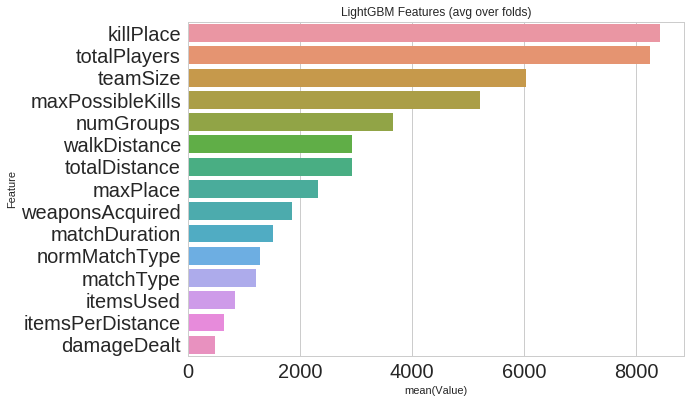

In [0]:
cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
cols_to_fit = [col for col in X_train.columns if col not in cols_to_drop]
feature_importance = pd.DataFrame(sorted(zip(lgbm.feature_importances_, cols_to_fit)), columns=['Value','Feature'])
feature_importance = feature_importance.tail(15)


plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig("lgbmfeatures.png",dpi=500)


## Regression Models

In [0]:
def runAllModels(X_train, Y_train):
        
    linear = LinearRegression(copy_X=True)
    linear.fit(X_train,Y_train)
    calculate_error(linear,"linear")

    ridge = Ridge(copy_X=True)
    ridge.fit(X_train,Y_train)
    calculate_error(ridge,"ridge")
    
    lasso = Lasso(copy_X=True)
    lasso.fit(X_train,Y_train)
    calculate_error(lasso,"lasso")
    
    elastic = ElasticNet(copy_X=True)
    elastic.fit(X_train,Y_train)
    calculate_error(elastic,"elastic")
    
    ada = AdaBoostRegressor(learning_rate=0.8)
    ada.fit(X_train,Y_train)
    calculate_error(ada,"Adaboost")
    
    GBR = GradientBoostingRegressor(learning_rate=0.8)
    GBR.fit(X_train,Y_train)
    calculate_error(GBR,"GBR")

    forest = RandomForestRegressor(n_estimators=10)
    forest.fit(X_train,Y_train)
    calculate_error(forest,"forest")
    
    tree = DecisionTreeRegressor()
    tree.fit(X_train,Y_train)
    calculate_error(tree,"tree")

In [0]:
runAllModels(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


linear
Mean Absolute Error is 0.08721
R2 score is 83.83%
ridge
Mean Absolute Error is 0.08715
R2 score is 83.84%
lasso
Mean Absolute Error is 0.12087
R2 score is 74.46%
elastic
Mean Absolute Error is 0.11303
R2 score is 77.10%


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-pack

Adaboost
Mean Absolute Error is 0.09713
R2 score is 82.85%
GBR
Mean Absolute Error is 0.05831
R2 score is 93.05%
forest


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Mean Absolute Error is 0.05743
R2 score is 93.03%
tree
Mean Absolute Error is 0.07706
R2 score is 86.99%
